In this notebook, I will implement the forward longitudinal vehicle model. The model accepts throttle inputs and steps through the longitudinal dynamic equations. After model creation I will be given a set of inputs that drives over a small road slope to test my model.

The input to the model is a throttle percentage $x_\theta \in [0,1]$ which provides torque to the engine and subsequently accelerates the vehicle for forward motion. 

The dynamic equations consist of many stages to convert throttle inputs to wheel speed (engine -> torque converter -> transmission -> wheel). These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

Where $T_e$ is the engine torque, $GR$ is the gear ratio, $r_{eff}$ is the effective radius, $m$ is the vehicle mass, $x$ is the vehicle position, $F_x$ is the tire force, and $F_{load}$ is the total load force. 

The engine torque is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ from an incline at angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear model.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}

Note that the absolute value is ignored for friction since the model is used for only forward motion ($\dot{x} \ge 0$). 
 
The tire force is computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

Where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 

I will use a Python class to encapsulate the longitudinal vehicle model. The vehicle begins with an initial velocity of 5 m/s and engine speed of 100 rad/s. All the relevant parameters are defined. The parameters can be divided into two categories: constants and state variables. The state variables are to be updated each iteration and they are { x, v, a, w_e, and w_e_dot }.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
 
        # ==================================
        #  Parameters
        # ==================================
    
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

I will now implement the vehicle model that will run after each time step. In the cell below I implement the combined engine dynamic equations along with the force equations. The function $\textit{step}$ takes the throttle $x_\theta$ and incline angle $\alpha$ as inputs and performs numerical integration over one timestep to update the state variables.

In [2]:
class Vehicle(Vehicle):
    def step(self, throttle, alpha):
        # ========================================================
        #  Calculate the different forces applied on the vehicle
        # ========================================================
        F_aero = self.c_a * self.v * self.v
        R_x = self.c_r1 * self.v
        F_g = self.m * self.g * np.sin(alpha)
        F_load = F_aero + R_x + F_g
        Torque_e = throttle * (self.a_0 + (self.a_1 * self.w_e) + (self.a_2 * (self.w_e ** 2)))
        Omega_w = self.GR * self.w_e
        s = (Omega_w * self.r_e - self.v)/self.v
        cs = self.c * s
        
        if abs(s) < 1:
            F_x = cs
        else:
            F_x = self.F_max
        
        # 
        # =============================
        #  Update the state variables
        # =============================
        self.x = self.x + (self.v * self.sample_time)
        self.v = self.v + (self.a * self.sample_time)
        self.a = (F_x - F_load)/self.m
        self.w_e = self.w_e + (self.w_e_dot * self.sample_time)
        self.w_e_dot = (Torque_e - (self.GR * self.r_e * F_load))/self.J_e
        
        pass

Next I create an instance of the Vehicle model that accepts a constant throttle input. In the xy plot below, the x-axis represents time and the y-axis represents the velocity of the vehicle. There are a few neat things to notice. First, the velocity converges to a fixed value because of aerodynamic drag and tire force limit. If you a(t) = dy/dx v(t), you would see that the acceleration will converge to 0 from the positive direction. A similar scenario can be seen when the incline angle $\alpha$ < 0. When the vehicle is traveling down a hill, the gravity will accelerate the vehicle to a terminal velocity where it is balanced by the drag force.

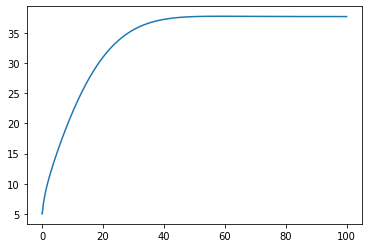

In [3]:
sample_time = 0.01
time_end = 100
model = Vehicle()

t_data = np.arange(0,time_end,sample_time)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 0.5

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.v
    model.step(throttle, alpha)
    
plt.plot(t_data, v_data)
plt.show()

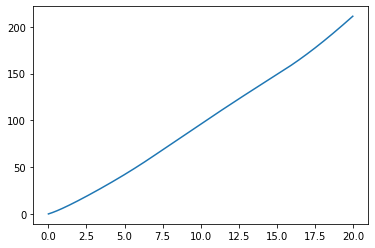

In [4]:
time_end = 20
t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)

# reset the states
model.reset()

for i in range(t_data.shape[0]):
    # Use the correct throttle value
    if i >= 0 and i <= 500:
        delta_throttle = (0.5-0.2)/500
        throttle = 0.2 + (delta_throttle * i)
    elif i > 500 and i < 1500:
        throttle = 0.5
    elif i >= 1500 and i < 2000:
        # throttle goes from 0.5 to 0 in 5 sec.
        # every 100 i I want to go down .001
        delta_throttle = 0.5 / 500
        throttle = 0.5 - (delta_throttle * (i-1500))
    
    # Compute the alpha value to pass into the model
    if model.x <= 60:
        alpha = 0.05
    elif model.x > 60 and model.x < 150:
        alpha = 0.1
    elif model.x >= 150:
        alpha = 0
        
    x_data[i] = model.x
    model.step(throttle, alpha)

# Plot x vs t for visualization
plt.plot(t_data, x_data)
plt.show()